# Проект: Сборный проект - 2

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Будет несколько задач:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

В проекте будет несколько блоков:
- загрузка данных и изучение общей информации;
- предобработка данных;
- выбор модели предсказания уровня удовлетворенности сотрудника:
    - исследовательский анализ;
    - корреляционный анализ;
    - обучение и выбор лучшей модели;
    - вывод;
- выбор модели предсказания увольнения из компании:
    - исследовательский анализ;
    - добавление нового входного признака;
    - корреляционный анализ;
    - обучение и выбор лучшей модели;
    - вывод;
- общий вывод.

## Загрузка данных и изучение общей информации

Для начала работы импортируем (установим) все необходимые в прокте библиотеки:

In [1]:
! pip install phik -q
! pip install scikit-learn --upgrade -q

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.impute import SimpleImputer

Загрузим все данные и посмотрим на них:

In [3]:
#Считываем данные и сохраняем в переменные

# тренировочные данные
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    
# тестовые данные
try:
    test_features = pd.read_csv('/datasets/test_features.csv')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    
# целевой признак для тестовых данных
try:
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

# выводим первые 5 строк каждого датафрейма
for i in train_job_satisfaction_rate, train_quit, test_features, test_target_job_satisfaction_rate, test_target_quit:
    display(i.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные считались корректно.

Посмотрим информацию о датафреймах с помощью метода `info()`:

In [4]:
# выводим информацию о каждом датафрейме
for i in train_job_satisfaction_rate, train_quit, test_features, test_target_job_satisfaction_rate, test_target_quit:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Посмотрим на информацию о признаках в датафреймах с помощью метода `describe`

In [5]:
# информация о признаках в датфреймах
for i in train_job_satisfaction_rate, train_quit, test_features, test_target_job_satisfaction_rate, test_target_quit:
    display(i.drop('id', axis=1).describe(include='all'))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,5,3,3,NaN,2,2,NaN,NaN,NaN
top,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,5,3,3,NaN,2,2,NaN,NaN,2
top,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,6,3,4,NaN,2,2,NaN,NaN
top,sales,junior,medium,NaN,no,no,NaN,NaN
freq,763,974,1043,NaN,1937,1738,NaN,NaN
mean,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


,quit
count,2000
unique,2
top,no
freq,1436


### Вывод по блоку

Вывод по первому блоку:
- данные загружены корректно;
- количественные данные в разумных пределах и в одинаковых пределах во всех датафреймах;
- типы данных соответствуют наполению;
- в `train_job_satisfaction_rate` и `test_features` есть пропуски в столбцах `dept` и `level`;
- в тестовой выборке в столбцах `dept` и `workload` уникальных значений на 1 больше чем в тренировочных.

## Предобработка данных

### Обработка пропусков

Посмотрим на строки с пропусками данных в `train_job_satisfaction_rate` и `test_features`:

In [6]:
# вывод строк с пустыми значениями в столбцах dept и level
for i in train_job_satisfaction_rate, test_features:
    for j in ('dept', 'level'):
        display(i[i.isna()[j]])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


Пропусков в данных не так много, лучшим вариантом будет заполнить их самыми наиболее часто встречающимися значениями в `pipeline` подготовки данных для моделирования в дальнейших шагах.

Посмотрим еще на уникальны значения столбцов `dept` и `workload` в `test_features`

In [7]:
# вывод уникальных значений
for i in ('dept', 'workload'):
    print(test_features[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['medium' 'low' 'high' ' ']


Вот они лишние значения - пробелы, посмотрим сколько их:

In [8]:
# вывод уникальных значений
for i in ('dept', 'workload'):
    print(test_features[i].value_counts())

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64


По одному пустому значению, заменим их на пустые значения:

In [9]:
# замена некорректных значений на пропуски
test_features[['dept', 'workload']] = test_features[['dept', 'workload']].replace(' ', np.nan)

Дальше они тоже заполнятся самыми наиболее часто встречающимися значениями в `pipeline` подготовки данных для моделирования в дальнейших шагах.

###  Проверка на наличие явных и неявных дубликатов

Посмотрим посмотрим на уникальные значения категориальных данных в датафреймах:

In [10]:
# перебираем уникальные значения столбцов с типом object всех датафреймов 
for i in train_job_satisfaction_rate, train_quit, test_features:
    for col in i.select_dtypes('object'):
        print(f'Уникальные значения столбца "{col}": {i[col].unique()} \n')

Уникальные значения столбца "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

Уникальные значения столбца "level": ['junior' 'middle' 'sinior' nan] 

Уникальные значения столбца "workload": ['medium' 'high' 'low'] 

Уникальные значения столбца "last_year_promo": ['no' 'yes'] 

Уникальные значения столбца "last_year_violations": ['no' 'yes'] 

Уникальные значения столбца "dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

Уникальные значения столбца "level": ['middle' 'junior' 'sinior'] 

Уникальные значения столбца "workload": ['high' 'medium' 'low'] 

Уникальные значения столбца "last_year_promo": ['no' 'yes'] 

Уникальные значения столбца "last_year_violations": ['no' 'yes'] 

Уникальные значения столбца "quit": ['no' 'yes'] 

Уникальные значения столбца "dept": ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan] 

Уникальные значения столбца "level": ['junior' 'middle' 'sinior' nan] 

Уникальные значения столбца "workload": ['medium' 'low' 'high' nan

Уникальные значения совпадают в разных датафреймах, ошибок нет.

Посмотрим на наличие явных дубликатов:

In [11]:
print('Количество явных дубликатов train_job_satisfaction_rate:', train_job_satisfaction_rate.duplicated().sum())
print('Количество явных дубликатов train_quit:', train_quit.duplicated().sum())
print('Количество явных дубликатов test_features:', test_features.duplicated().sum())

Количество явных дубликатов train_job_satisfaction_rate: 0
Количество явных дубликатов train_quit: 0
Количество явных дубликатов test_features: 0


Полных дубликатов нет, посмотрим на количество дубликатов без столбца `id`:

In [12]:
print('Количество неявных дубликатов train_job_satisfaction_rate:', train_job_satisfaction_rate.drop('id', axis=1).duplicated().sum())
print('Количество неявных дубликатов train_quit:', train_quit.drop('id', axis=1).duplicated().sum())
print('Количество неявных дубликатов test_features:', test_features.drop('id', axis=1).duplicated().sum())

Количество неявных дубликатов train_job_satisfaction_rate: 245
Количество неявных дубликатов train_quit: 1413
Количество неявных дубликатов test_features: 557


Неявных дубликатов очень много особенно в `train_quit`, удалим их:

In [13]:
# удаление неявных дубликатов в train_job_satisfaction_rate
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates(subset=['dept', 'level', 'workload', 
                                                                                  'employment_years', 'last_year_promo', 
                                                                                  'last_year_violations', 
                                                                                  'supervisor_evaluation', 'salary', 
                                                                                  'job_satisfaction_rate'])

print(f'Размер датафрейма train_job_satisfaction_rate: {train_job_satisfaction_rate.shape}')

# удаление неявных дубликатов в train_quit
train_quit = train_quit.drop_duplicates(subset=['dept', 'level', 'workload','employment_years', 'last_year_promo', 
                                                'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'])

print(f'Размер датафрейма train_quit: {train_quit.shape}')

# удаление неявных дубликатов в test_features
test_features = test_features.drop_duplicates(subset=['dept', 'level', 'workload','employment_years', 'last_year_promo',
                                                      'last_year_violations', 'supervisor_evaluation', 'salary'])

print(f'Размер датафрейма test_features: {test_features.shape}')

Размер датафрейма train_job_satisfaction_rate: (3755, 10)
Размер датафрейма train_quit: (2587, 10)
Размер датафрейма test_features: (1443, 9)


Размеры датафреймов значительно уменьшились.

### Вывод по блоку

Выводы по предобработке данных:
- найдены пропуски и некорректные значения в некоторых столбцах, они будут обработаны в `pipeline` подготовки данных;
- удалены неявные дубликаты.

## Выбор модели предсказания уровня удовлетворенности сотрудника

### Исследовательский анализ

#### Исследовательский анализ количественных признаков

Построим гистограммы (барплота) и "ящики с усами" для количественных признаков, предварительно создав функцию для их построения:

In [14]:
# создадим функцию для построения гистограммы (барплота) и ящика с усами для количетсвенных признаков
def hist_and_boxplot_num_col (df, parametr, type_plot):
    # вывод числового описания данных
    print(df[parametr].describe())
    
    # выбор количества корзин
    if ((len(df[parametr].unique())) >= 20):
        bins = 20
    else:
        bins = len(df[parametr].unique())
    
    # построение фигур для графиков
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    plt.suptitle(f'Распределение признака {parametr}', fontsize=20)
    
    # построение гистограммы
    if type_plot == 'hist':
        df[parametr].hist(bins=20, grid=True, ax=axes[0])
        axes[0].set_ylabel('Количество', fontsize=15)
        axes[0].set_xlabel(f'Значение {parametr}', fontsize=15)
    # или столбчатого графика
    elif type_plot == 'bar':
        df.groupby(by=parametr)[parametr].count().plot.bar(grid=True, ax=axes[0])
        axes[0].set_ylabel('Количество', fontsize=15)
        axes[0].set_xlabel(f'Значение {parametr}', fontsize=15)
    else:
        print('Неизвестный тип графика')
        
    # построение ящика с усами
    df.boxplot(column=parametr, ax=axes[1])
    axes[1].set_ylabel(f'Значение {parametr}', fontsize=15)
    
    plt.show()

Посмотрим как распеределена длительность работы в компании (в годах) `employment_years`:

count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


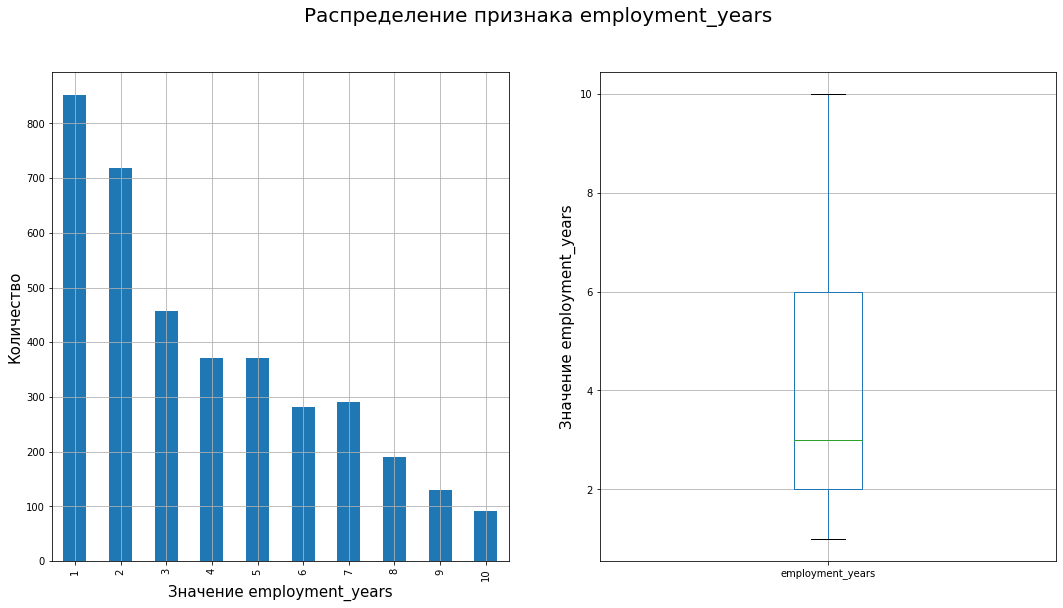

In [15]:
hist_and_boxplot_num_col(train_job_satisfaction_rate, 'employment_years', 'bar')

По графику видно, что больше всего в компании новичков, и чем больше стаж,тем меньше количество сотрудников в этой группе.

Посмотрим на распределение оценки качества работы сотрудника, которую дал руководитель `supervisor_evaluation`:

count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


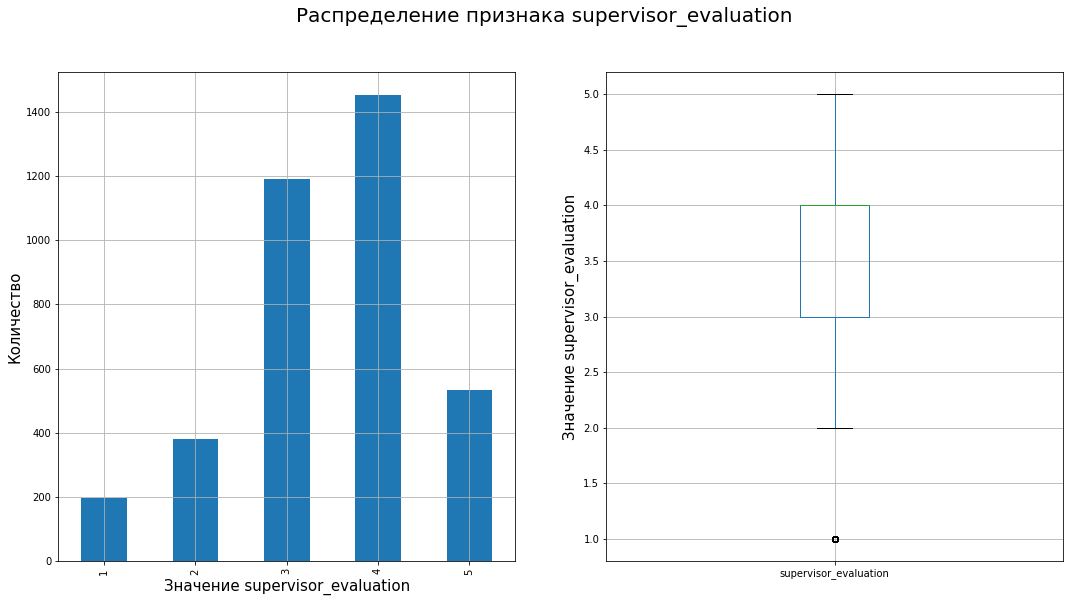

In [16]:
hist_and_boxplot_num_col(train_job_satisfaction_rate, 'supervisor_evaluation', 'bar')

В основном руководитель оценивает сотрудников на 3 и 4.

Посмотрим на распределение ежемесячной зарплаты сотрудников `salary`:

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


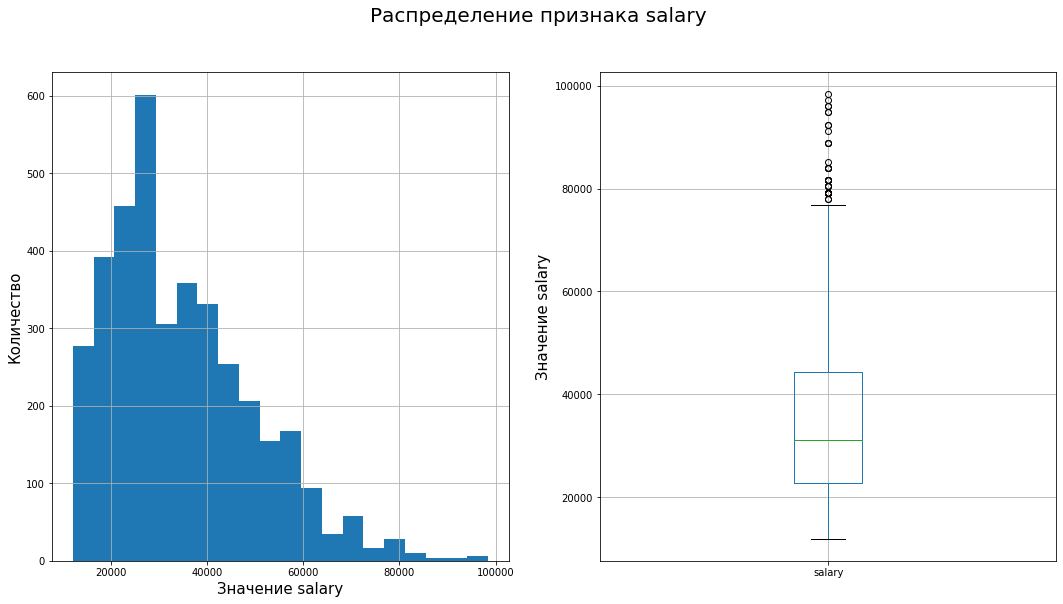

In [17]:
hist_and_boxplot_num_col(train_job_satisfaction_rate, 'salary', 'hist')

Видно, что:
- основная масса сотрудников получает зарплату до 60000 рублей;
- распределение не похоже на нормальное.

Посмотрим как распределен целевой признак: уровень удовлетворённости сотрудника работой в компании `job_satisfaction_rate`:

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


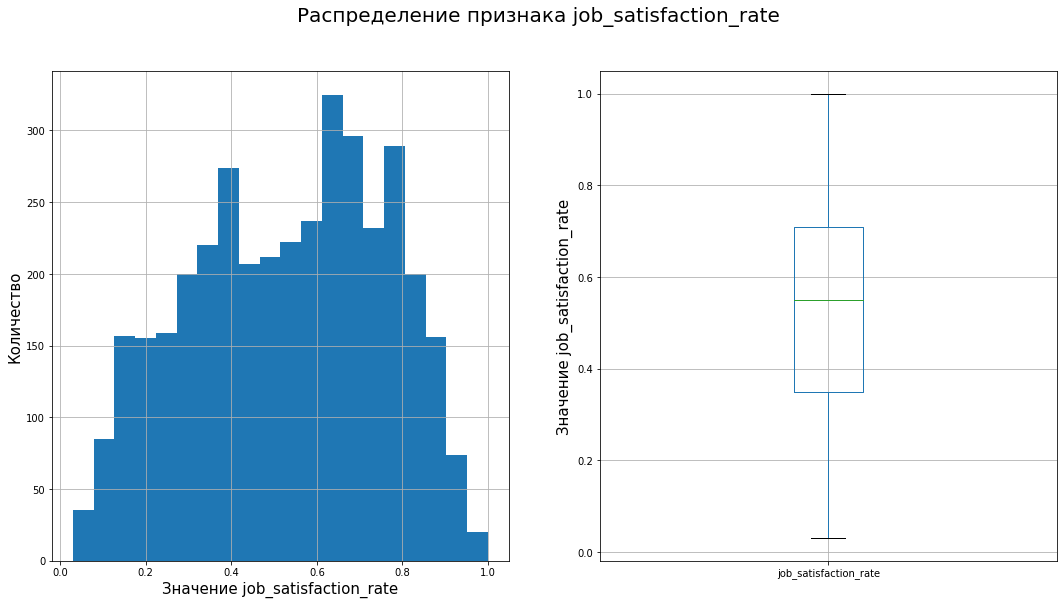

In [18]:
hist_and_boxplot_num_col(train_job_satisfaction_rate, 'job_satisfaction_rate', 'hist')

По графику видно, что:
- сотрудников удовлетворенных полностью мало;
- половина сотрудников удовлетворена от 0,35 до 0,7. 

#### Исследовательский анализ категориальных признаков

Сначала также создадим функцию, которая будет строить графики для категориальных переменных:

In [19]:
# создадим функцию для построения барплота для категориальных признаков
def barplot_cat_col (df):
    # создание фигуры для графиков
    fig, axes = plt.subplots(3, 2, figsize=(18, 27))
    
    # построение барплота
    for i, j in zip(list(df.select_dtypes('object')), range(6)):
        df.groupby(by=i)[i].count().plot.bar(
            grid=True, # сетка
            rot=0,
            ax=axes[j // 2, j % 2]
        )
        axes[j // 2, j % 2].set_ylabel('Количество сотрудников', fontsize=15)
        axes[j // 2, j % 2].set_xlabel(f'Признак: {i}', fontsize=15)
        axes[j // 2, j % 2].set_title(f'Распределение покупателей по признаку: \n{i}', fontsize=20)

Посмотрим на распределение категориальных признаков:

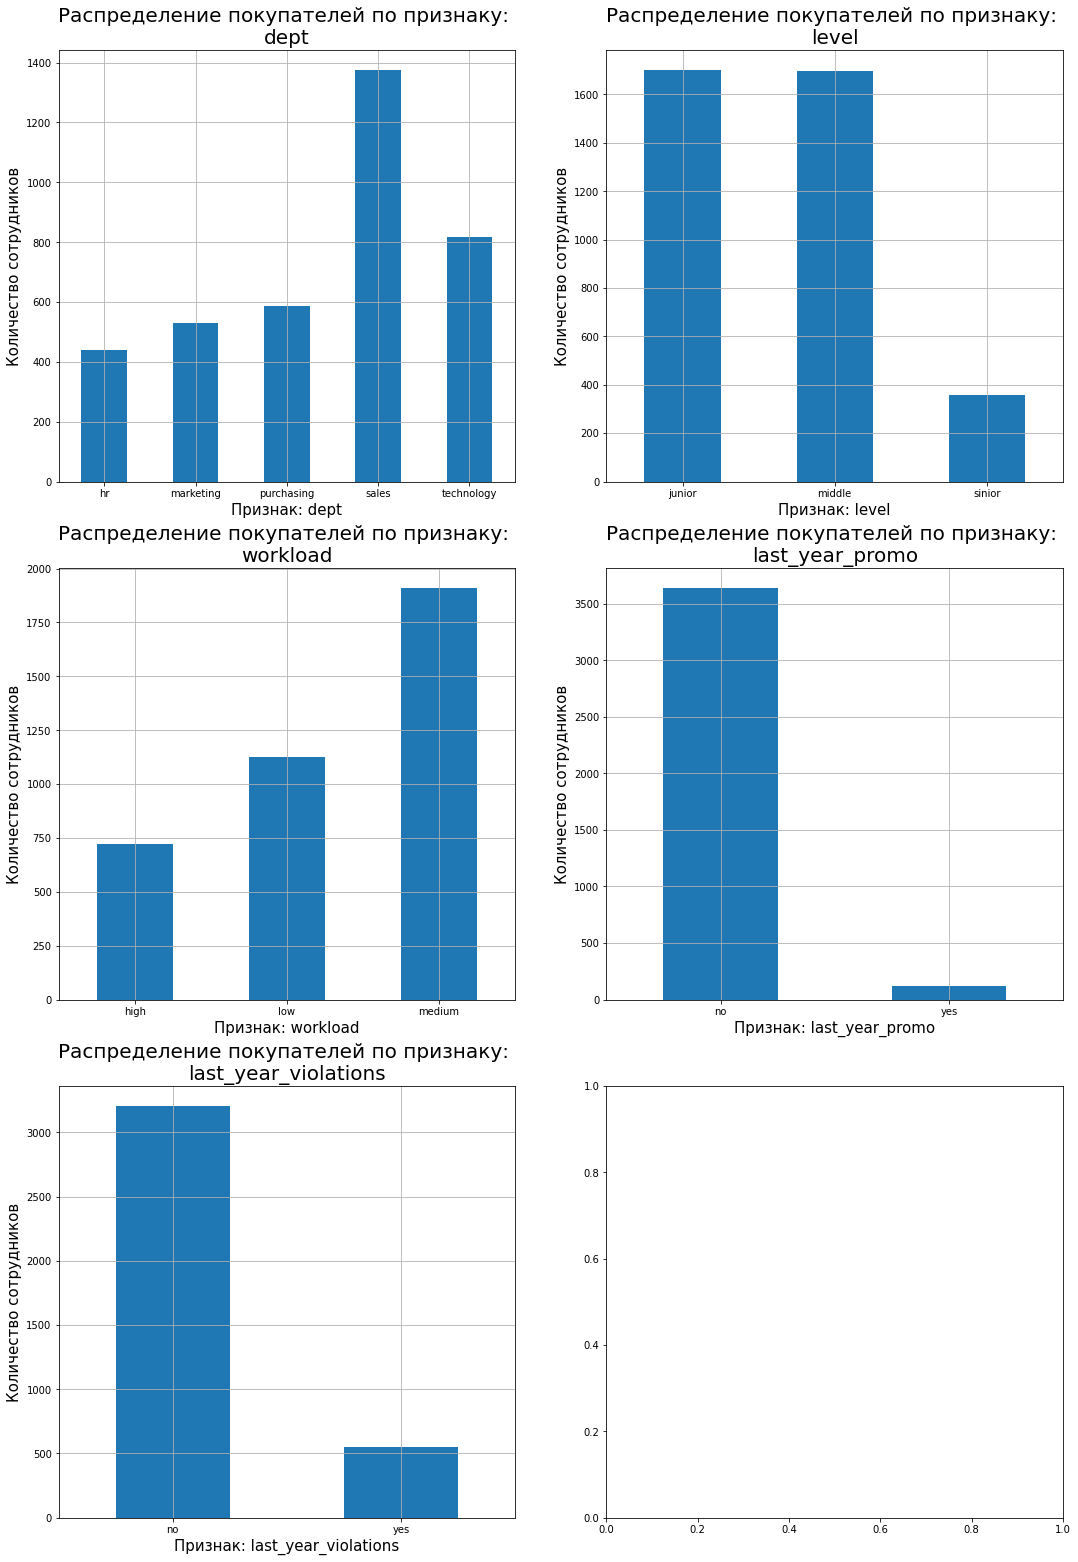

In [20]:
# посторение барплотов для категориальных переменных
barplot_cat_col(train_job_satisfaction_rate)

По графикам видно, что:
- больше всего сотрудников в отделе `sales`, делее по количеству идет отдел `technology` и сотрудников в других отделах в два раза меньше чем в `sales`;
- количество сотрудников по уровню занимаемой должности `junior` и `middle` примерно равны, а вот `sinior` почти в пять раз меньше;
- всех больше сотрудников с загруженность `medium`, затем идут сотрудники с загруженностью `low` и всех меньше сотрудников с загруженностью `high`;
- очень малая часть сотрудников получила повышение за последний год;
- чуть больше 500 сотрудников совершали нарушения трудового договора.

#### Вывод по исследовательскому анализу

Вывод по исследовательскому анализу:
- сотрудников, работающих недавно больше, чем "стареньких" сотрудников;
- в основном руководитель оценивает сотрудников на 3 или 4;
- большая часть сотрудников получает низкую зарплату;
- самый большой отдел - `sales`;
- больше всего сотрудников `junior` и `middle`;
- всех больше сотрудников с загруженность `medium`;
- очень малая часть сотрудников получила повышение за последний год;
- чуть больше 500 сотрудников совершали нарушения трудового договора.

### Корреляционный анализ

Для нахождения зависимостей признаков воспользуемся коэффициентом Фи (признаки: `employment_years` и `supervisor_evaluation` больше похожи на категориальные признаки (мало уникальных значений) не будем их указывать в параметре `interval_cols`, где отобразим непрерывные признаки):

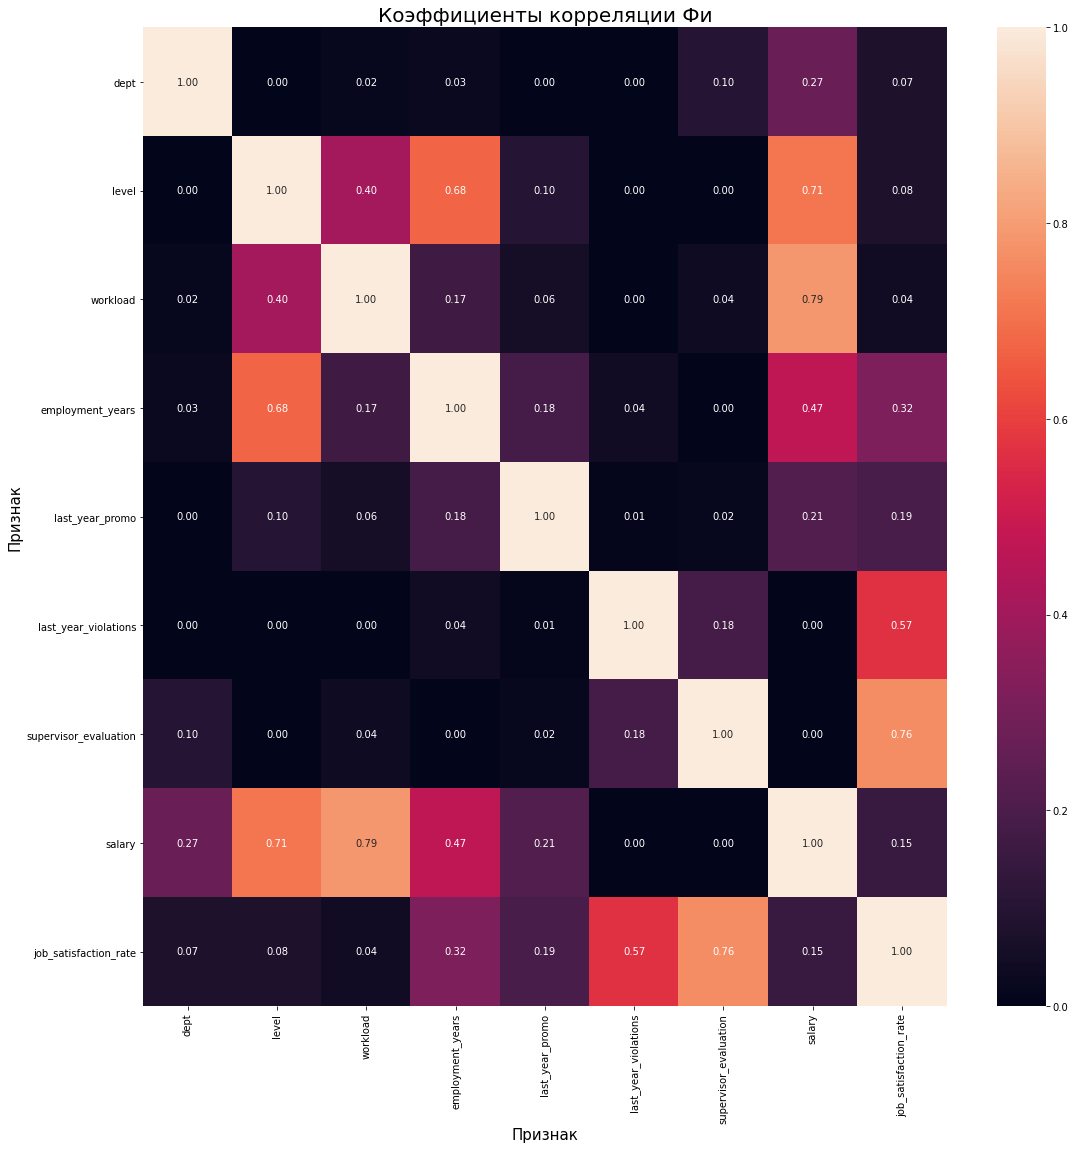

In [21]:
plt.subplots(figsize=(18, 18))
# тепловая карта коэффициентов корреляции Фи
sns.heatmap(train_job_satisfaction_rate.drop('id', axis=1)
            .phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), 
            annot=True, 
            fmt=".2f")
plt.ylabel('Признак', fontsize=15)
plt.xlabel('Признак', fontsize=15)
plt.title('Коэффициенты корреляции Фи', fontsize=20)
plt.show()

По тепловой карте коэффициентов Фи видно, что:
- целевой признак `job_satisfaction_rate` средне коррелирует с оценкой качества работы сотрудника, которую дал руководитель `supervisor_evaluation` и наличием нарушения сотрудником трудового договора за последний год `last_year_violations` (коэффициент Фи 0,76 и 0,57 соответственно);
- также целевой признак совсем немного коррелирует с длительностью работы в компании `employment_years` (коэффициент Фи 0,32);
- с остальными признаками целевой признак практически не коррелирует;
- есть высокая корреляция у `level` с `salary` и `employment_years`, а также у `salary` и `workload`, но о мультиколлинеарности речи не идет.

### Обучение и выбор лучшей модели предсказания уровня удовлетворенности сотрудника

Кодировать данные будем двумя кодировщиками:
- `OneHotEncoder`;
- `OrdinalEncoder`.

В кодировщик `OrdinalEncoder` передадим названия тех столбцов, где есть ранжирование:
- `level`;
- `workload`.

Создадим списки с названиями признаков (для кодирования и масштабирования):

In [22]:
# создаём списки с названиями признаков:
# для кодировщика OneHotEncoder
ohe_columns = ['dept', 
               'last_year_promo', 
               'last_year_violations']

# для кодировщика OrdinalEncoder
ord_columns = ['level', 
               'workload']

# для масштабирования
num_columns = ['employment_years',
               'supervisor_evaluation',
               'salary']

Дальше создадим пайплайны для кодирования признаков (пропуски и неизвестные значения будем заменять на более частотные с помощью `SimpleImputer`):

In [23]:
# создадим пайплайн для подготовки признаков из списка ohe_columns с OneHotEncoder:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]
    )

# создадим пайплайн для подготовки признаков из списка ord_columns с OrdinalEncoder: 
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим пайплайн `data_preprocessor` для объединения закодированных и отмасштабированных данных:

In [24]:
# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн `pipe_final`, которы включает:
- пайплайн для подготовки данных `data_preprocessor`;
- модель:

In [25]:
# создадим итоговый пайплайн:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Дальше создадим словарь с гиперпараметрами моделей, которые будем пробовать для предсказания покупательской активности:
- `LinearRegression()`:
- `DecisionTreeClassifier()`:
    - ограничим максилальную глубину дерева `max_depth` от 8 до 15;
    - число листьев `max_features`: `sqrt`, `log2`, `None`;
    - минимальное число объектов в листе `min_samples_leaf`: 1, 3 и 5;
    - критерий, по которому происходит разбиение вершины дерева `criterion`: `squared_error`, `friedman_mse`, `absolute_error`, `poisson`;
- для всех моделей переберем два варианта масштабирования: `StandardScaler`, `MinMaxScaler`:

In [26]:
param_distributions_job_satisfaction_rate = [
    # словарь для модели LinearRegression() 
    {
        'models':[LinearRegression()], # модель
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] # два варианта масштабирования
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=42)], # модель
        'models__max_depth': range(8, 15), # ограничение максимальной глубины дерева
        'models__max_features': ['sqrt', 'log2', None], # число листьев
        'models__min_samples_leaf': [1, 3, 5], # минимальное число объектов в листе
        'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], # критерий
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] # два варианта масштабирования
    }
]

Словарь готов.

Теперь создадим функцию для метрики SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»):

In [27]:
# функцию для расчёта метрики «симметричное среднее абсолютное процентное отклонение» SMAPE
def SMAPE(y_true, y_pred):
    a = abs(y_true - y_pred)
    b = (abs(y_true) + abs(y_pred)) / 2
    metric = 100 / len(y_true) * (a / b).sum()
    return metric

Функция готова, теперь создадим тренировочную выборку:

In [28]:
# создание тренировочной выборки и y_train_job_satisfaction_rate
X_train_job_satisfaction_rate = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train_job_satisfaction_rate = train_job_satisfaction_rate['job_satisfaction_rate']

Тренировочная выборка готова, теперь с помощью `RandomizedSearchCV` выберем лучшую модель на основе метрики `SMAPE` (чем меньше метрика, тем лучше) и посмотрим на параметры лучшей модели и ее метрику:

In [29]:
# выбор лучшей модели с помощью RandomizedSearchCV
randomized_search_job_satisfaction_rate = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions_job_satisfaction_rate, 
    cv=5,
    random_state=5,
    scoring=make_scorer(SMAPE, greater_is_better=False),
    n_jobs=-1
)

# обучение лучшей модели на тренировочной выборке
randomized_search_job_satisfaction_rate.fit(X_train_job_satisfaction_rate, y_train_job_satisfaction_rate)

# параметры лучшей модели
params_best_model = (pd.DataFrame(randomized_search_job_satisfaction_rate.cv_results_)[['rank_test_score', 'params']]
                     .sort_values('rank_test_score')
                     .reset_index(drop=True)['params']
                     .loc[pd.DataFrame(randomized_search_job_satisfaction_rate.cv_results_).index[0]]
                    )

print('Лучшая модель и её параметры:\n\n', params_best_model)
print ('\nМетрика лучшей модели на тренировочной выборке:', -(randomized_search_job_satisfaction_rate.best_score_.round(2)))

Лучшая модель и её параметры:

 {'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 3, 'models__max_features': None, 'models__max_depth': 14, 'models__criterion': 'poisson', 'models': DecisionTreeRegressor(random_state=42)}

Метрика лучшей модели на тренировочной выборке: 15.23


Лучшей оказалась модель `DecisionTreeRegressor` с параметрами:
- максилальная глубина дерева `max_depth` 14;
- число листьев `max_features`: неограничено - `None`;
- минимальное число объектов в листе `min_samples_leaf`: 3;
- критерий, по которому происходит разбиение вершины дерева `criterion`: `poisson`;
- масштабирование: `MinMaxScaler`;
- метрика `SMAPE` при кросс-валидации получилась равной 15,23.

Проверим как ведет себя модель на треноровочных данных, но для начала необходимо сформировать `y_test_job_satisfaction_rate`, для этого добавим целевой признак `test_target_job_satisfaction_rate` к тестовой выборке `test_features` по `id` и отделим его в отдельный `y_test_job_satisfaction_rate`:

In [30]:
# добавление целевого признака к тренировочным данным
test_features = test_features.merge(test_target_job_satisfaction_rate,
                                      on='id',
                                      how='left'
                                     )

print(f"""
Размер test_features: {test_features.shape}
Количество пропусков в столбце целевого признака job_satisfaction_rate: {test_features["job_satisfaction_rate"].isna().sum()}
"""
     )

# выделение целевого признака тренировочной выборки в y_test_job_satisfaction_rate
y_test_job_satisfaction_rate = test_features['job_satisfaction_rate']


Размер test_features: (1443, 10)
Количество пропусков в столбце целевого признака job_satisfaction_rate: 0



Целевой признак добавился корректно (нет пропусков).

Обучим модель на тренировочных данных (`X_train_job_satisfaction_rate`, `y_train_job_satisfaction_rate`), получим предсказания на тестовых `test_features` (без `id` и целевого признака `job_satisfaction_rate`) и посчитаем метрику `SMAPE`:

In [31]:
# получение лучшей модели из pipeline
best_model_job_satisfaction_rate = randomized_search_job_satisfaction_rate.best_estimator_

# обучение лучшей модели
best_model_job_satisfaction_rate.fit(X_train_job_satisfaction_rate, y_train_job_satisfaction_rate)

# получение предсказаний тестовой выборки
y_preds_job_satisfaction_rate = best_model_job_satisfaction_rate.predict(test_features.drop(['id', 'job_satisfaction_rate'], 
                                                                                            axis=1))

print(f'Метрика SMAPE на тестовой выборке: {round(SMAPE(y_test_job_satisfaction_rate, y_preds_job_satisfaction_rate), 2)}')

Метрика SMAPE на тестовой выборке: 14.85


Критерий успеха был: SMAPE ≤ 15 на тестовой выборке, модель удовлетворяет этому условию.

### Вывод

Вывод по модели предсказания уровня удовлетворенности сотрудника:
- выбор был из двух моделей `LinearRegression` и `DecisionTreeRegressor`, лучшей оказалась более сложная модель, т.к. простая модель `LinearRegression` не смогла установить все зависимости, т.к. целевой признак не сильно коррелировал с входными признаками;
- лучшей для предсказания уровня удовлетворенности сотрудника стала модель `DecisionTreeRegressor` с параметрами:
    - максилальная глубина дерева `max_depth` 14;
    - число листьев `max_features`: неограничено - `None`;
    - минимальное число объектов в листе `min_samples_leaf`: 3;
    - критерий, по которому происходит разбиение вершины дерева `criterion`: `poisson`;
    - масштабирование: `MinMaxScaler`;
- метрика `SMAPE` при на тестовой выборке получилась равной 14,85, что даже лучше чем, при кросс-валидации на тренировочных данных (15,23).

## Выбор модели предсказания увольнения из компании

### Исследовательский анализ

#### Исследовательский анализ количественных признаков

Посмотрим на распределение количественных признаков в `train_quit`:

count    2587.000000
mean        4.213375
std         2.601105
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


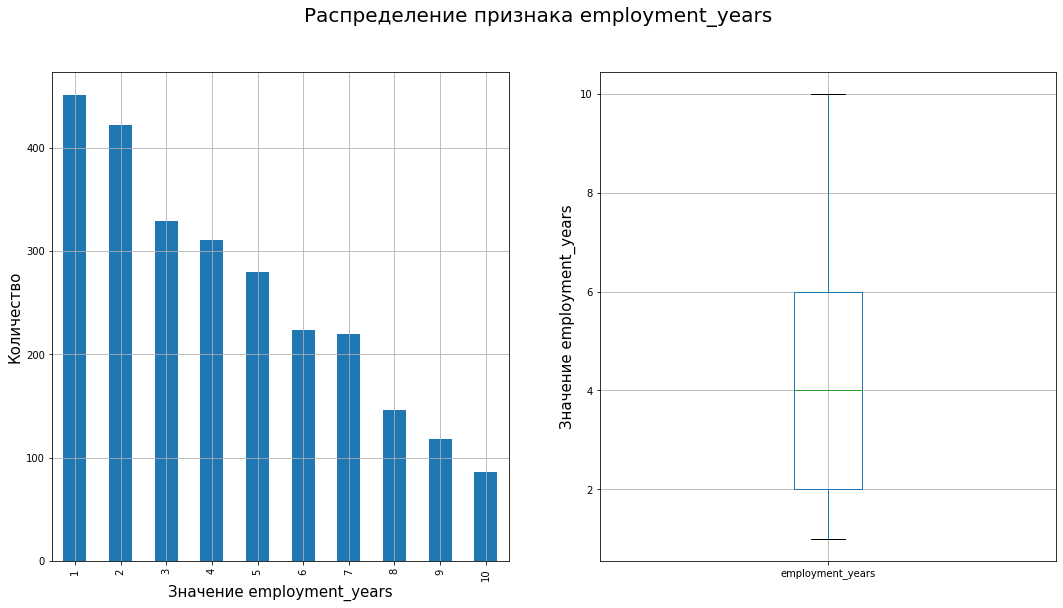

In [32]:
hist_and_boxplot_num_col(train_quit, 'employment_years', 'bar')

count    2587.000000
mean        3.367994
std         1.080243
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


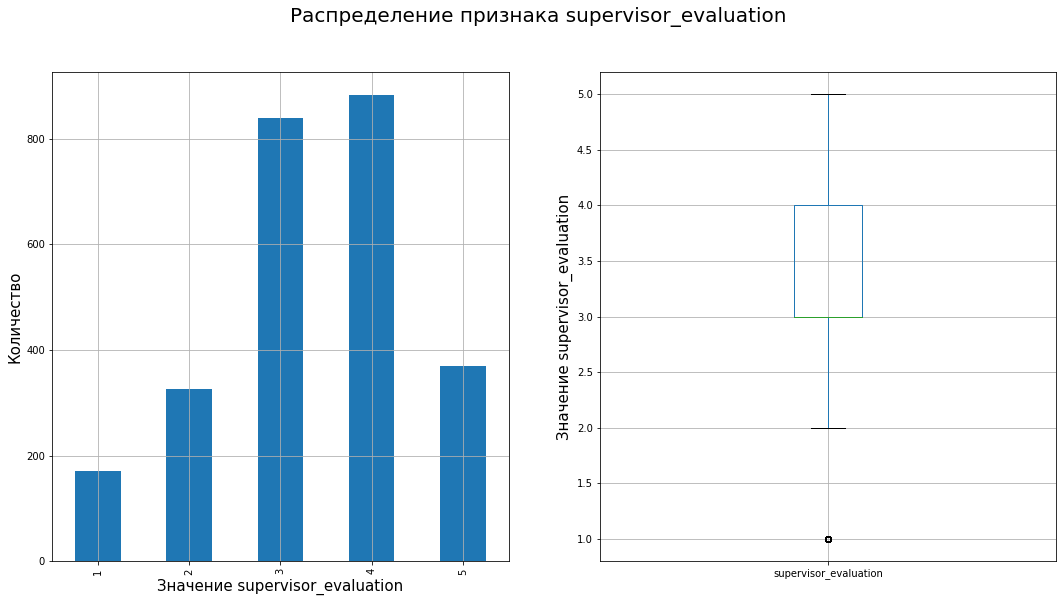

In [33]:
hist_and_boxplot_num_col(train_quit, 'supervisor_evaluation', 'bar')

count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


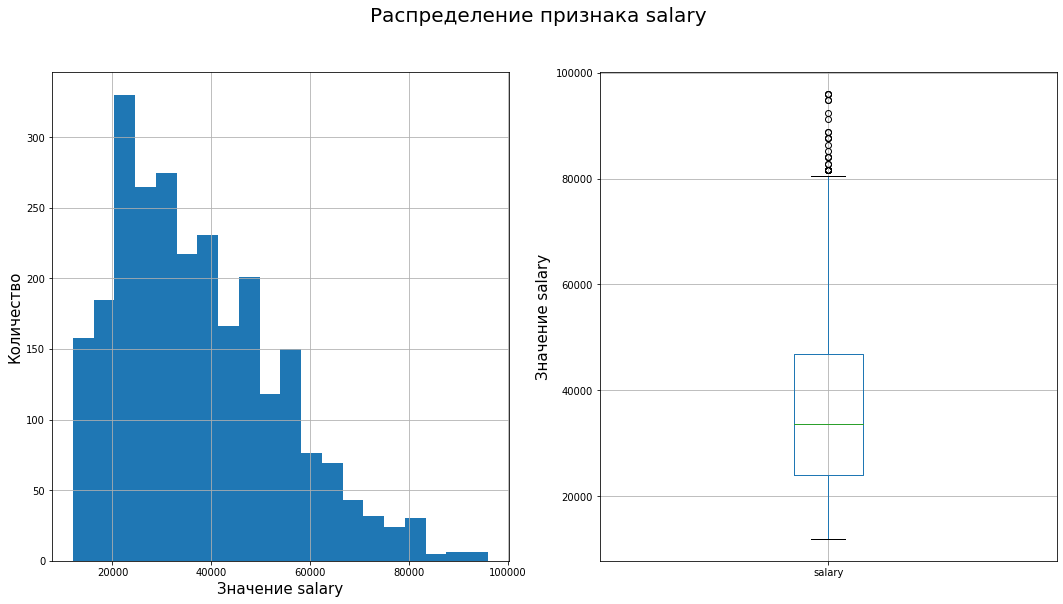

In [34]:
hist_and_boxplot_num_col(train_quit, 'salary', 'hist')

Видно, что все признаки распределены также как и в `train_job_satisfaction_rate`.

#### Исследовательский анализ категориальных признаков

Посмотрим на распределение категориальных признаков:

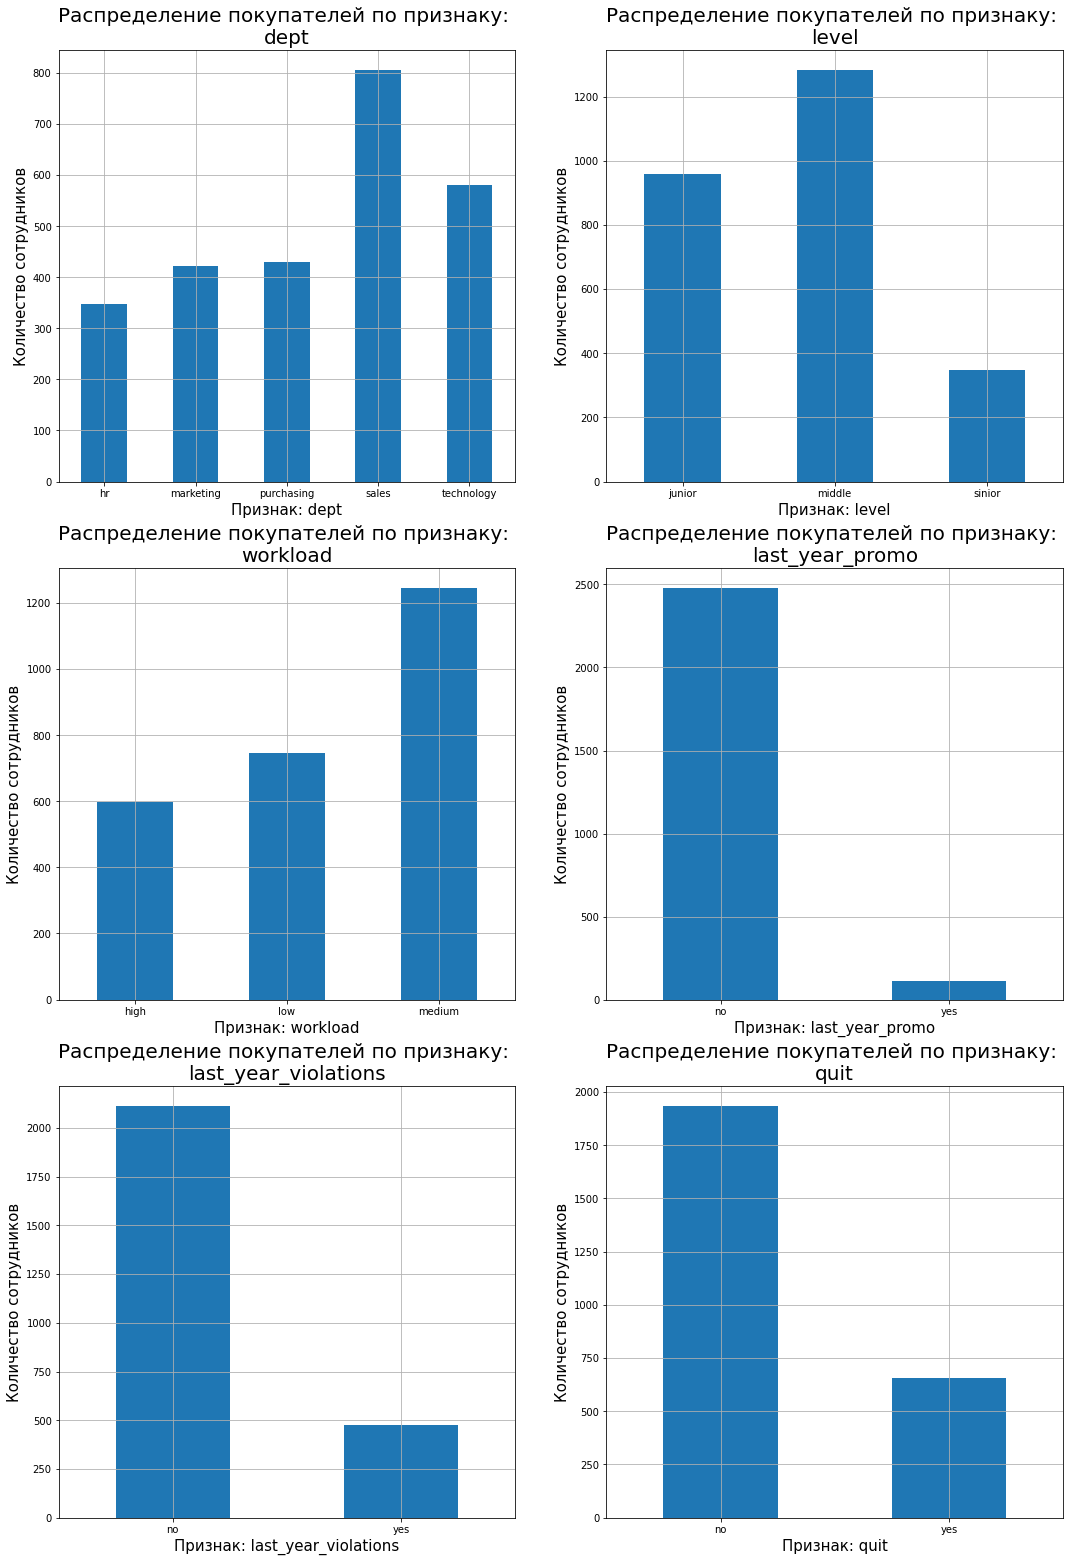

In [35]:
# посторение барплотов для категориальных переменных
barplot_cat_col(train_quit)

Видно, что:
- все признаки распределены также как и в `train_job_satisfaction_rate`, только сотрудников с уровнем `middle` больше чем `junior`, в `train_job_satisfaction_rate` их было поровну;
- оставшихся сотрудников в три зара больше, чем сотрудников, которые уволились.

#### Портрет «уволившегося сотрудника»

Посмотрим на распределение количественных признаков с разбивкой на уволившихся и оставшихся сотрудников (добавим еще на график линию среднего значения признака):

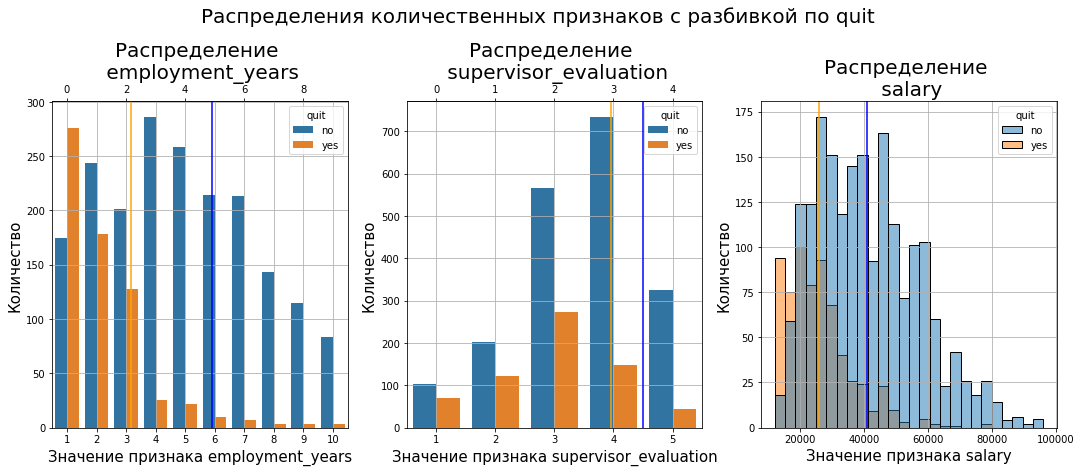

In [36]:
# создаем сетку для гистограмм
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# название сетки
plt.suptitle('Распределения количественных признаков с разбивкой по quit', fontsize=20, y=1.1)

# построение гистограмм (барплота) с разбивкой по целевому признаку + среднее значение
for i, j in zip(range(3), list(train_quit.drop(['id'], axis=1).select_dtypes([np.number]))):
    if train_quit[j].nunique() < 15:
        sns.barplot(data=train_quit.groupby([j, 'quit']).count().reset_index(), x=j, y='id', hue='quit', ax=axes[i])
        axes[i].secondary_xaxis('top')
    else:
        sns.histplot(train_quit, x=j, hue='quit', ax=axes[i])
    axes[i].set_title(f'Распределение \n {j}', fontsize=20)
    axes[i].set_ylabel(f'Количество', fontsize=15)
    axes[i].set_xlabel(f'Значение признака {j}', fontsize=15)
    axes[i].grid()
    axes[i].axvline(train_quit.query('quit == "no"')[j].mean(),  color='blue')
    axes[i].axvline(train_quit.query('quit == "yes"')[j].mean(), color='orange')


По графикам видно, что:
- в среднем уволившиеся сотрудники работали около двух лет, а оставшиеся в компании работаю там в среднем пять лет;
- уволившихся сотрудников со стажем один год, больше чем оставшихся сотрудников с таким же стажем; 
- средняя оценка уволившихся сотрудников в среднем меньше, чем сотрудников оставшихся в компании (3 и 3,5 соответственно);
- средняя зарплата ушедших сотрудников ниже, зарплаты оставшихся сотрудников.

Посмотрим на распределение категориальных признаков с разбивкой на уволившихся и оставшихся сотрудников:

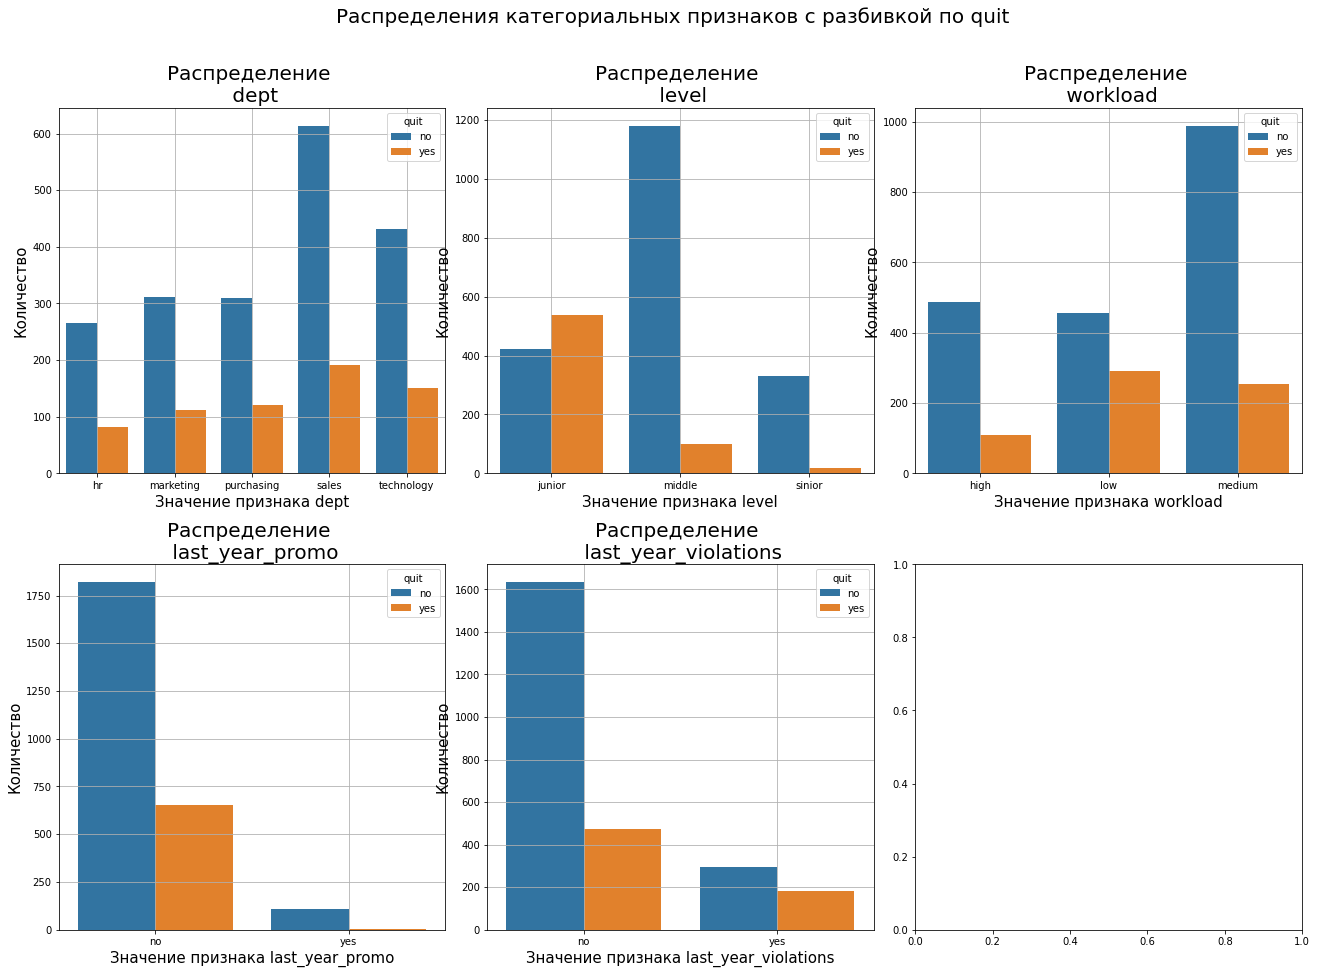

In [37]:
# создаем сетку для гистограмм
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# разносим графики
fig.tight_layout(h_pad=7)

# название сетки
plt.suptitle('Распределения категориальных признаков с разбивкой по quit', fontsize=20, y=1.1)

# построение барплотов с разбивкой по целевому признаку
for i, j in zip(range(5), list(train_quit.drop(['id', 'quit'], axis=1).select_dtypes('object'))):
    sns.barplot(data=train_quit.groupby([j, 'quit']).count().reset_index(), x=j, y='id', hue='quit', ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Распределение \n {j}', fontsize=20)
    axes[i // 3, i % 3].set_ylabel(f'Количество', fontsize=15)
    axes[i // 3, i % 3].set_xlabel(f'Значение признака {j}', fontsize=15)
    axes[i // 3, i % 3].grid()

Построим еще графики, где будет видно соотношение сотрудников:

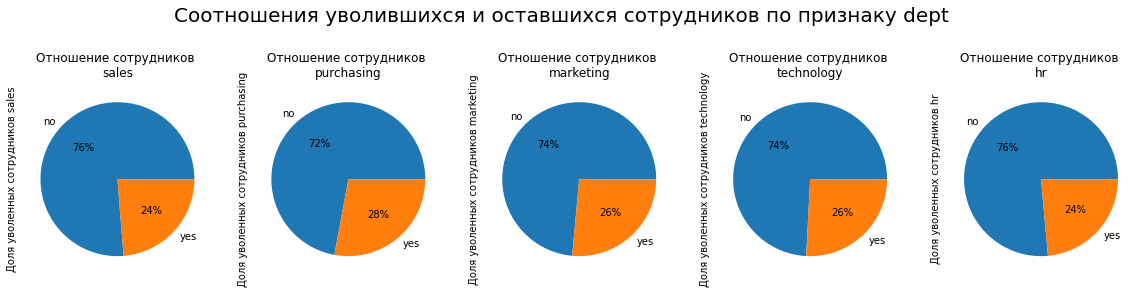

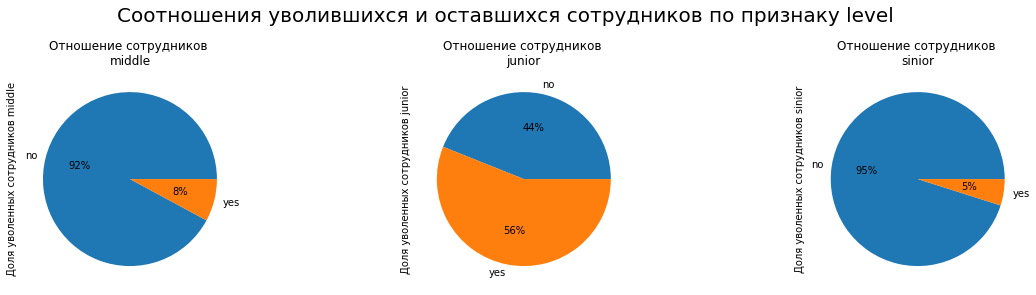

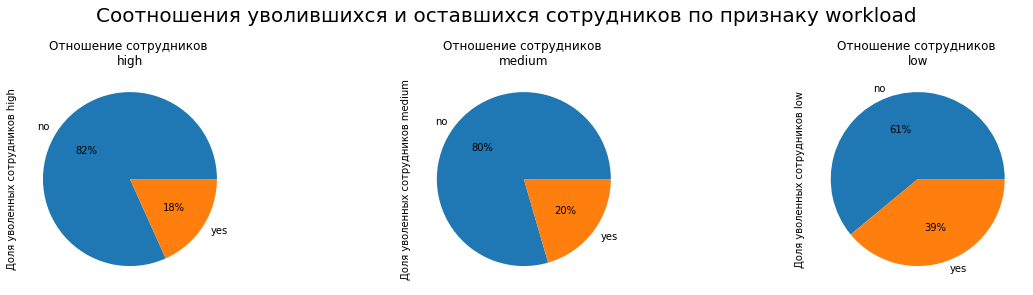

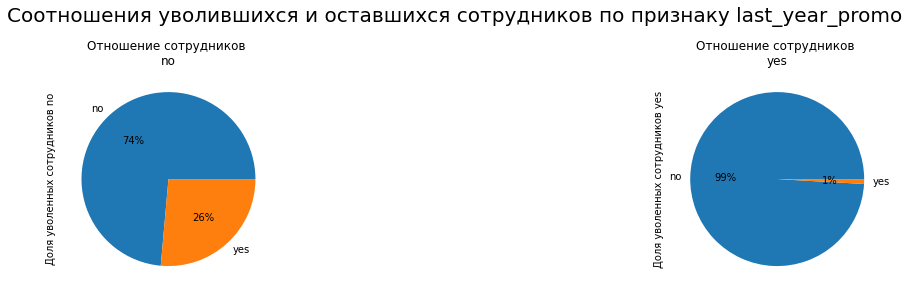

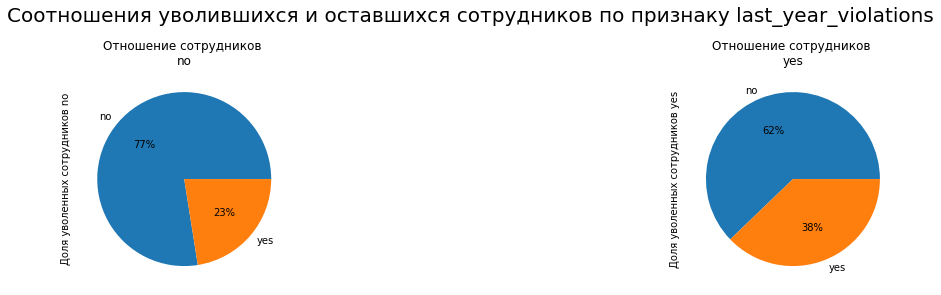

In [38]:
# перебираем категориальные признаки
for k in train_quit.drop(['id', 'quit'], axis=1).select_dtypes('object').columns:
    
    # фигура для графиков в зависимости от количества уникальных значений признаков
    fig, axes = plt.subplots(nrows=1, ncols=len(train_quit[k].unique()), figsize=(20, 4))
    plt.suptitle(f'Соотношения уволившихся и оставшихся сотрудников по признаку {k}', fontsize=20, y=1.1)
    
    # перебираем уникальные значения признаков и строим pie-график
    for i, j in zip(train_quit[k].unique(), range(len(train_quit[k].unique()))):
        train_quit.groupby([k, 'quit']).count().reset_index().set_index(k).loc[[i]].set_index('quit')['id'].plot(
            kind='pie', # вид
            y=k, # данные для графика
            autopct='%1.0f%%', # подписи в %
            ax=axes[j],
            ylabel=(f'Доля уволенных сотрудников {i}'),
            title=(f'Отношение сотрудников \n{i}')
        )

По графикам и диаграммам видно, что:
- распределение по отделам уволившихся сотрудников примерно повторяет распределение сотрудников оставшихся в компании, но всех больше сотрудников уволилось в отделе `purchasing` (28%), затем идут отделы `marketing` и `technology` (26%) и всех меньше увольнений в отделах `sales` и `hr` (24%);
- больше всего уволившихся сотрудников имели уровень занимаемой должности `junior`, в компании осталось меньше `junior`, чем уволилось (44% на 56%);
- по уровню загруженности уволенные сотрудники в основном были `low` и `medium`, доли уволившихся сотрудников по уровню `medium` и `high` примерно равны (20% и 18% соответственно), доля уволившихся сотрудников с загруженностью `low` 39%;
- лишь пара человек после повышения ушли из компании (1%), в основном уходили сотрудники не получавшие повышения (26%);
- 38% сотрудников, имевших наружения трудового договора, уволились и всего 23% струдников, не нарушавших трудовой договор, уволились.

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение на тестовой выборке, где есть оба целевых признака, но для начала добавим целевой признак `quit` к тестовой выборке и сразу выдели его отдельно в `y_test_quit`:

In [39]:
# добавление целевого признака к тренировочным данным
test_features = test_features.merge(test_target_quit, on='id', how='left')

print(f"""
Размер test_features: {test_features.shape}
Количество пропусков в столбце целевого признака quit: {test_features["quit"].isna().sum()}
"""
     )

# выделение целевого признака тренировочной выборки в y_test
y_test_quit = test_features['quit']


Размер test_features: (1443, 11)
Количество пропусков в столбце целевого признака quit: 0



Целевой признак добавился корректно (строки не потерялись, пропусков нет).

Теперь посмотрим на гистограмму распределения уровня удовлетворенности с разбивкой по `quit`:

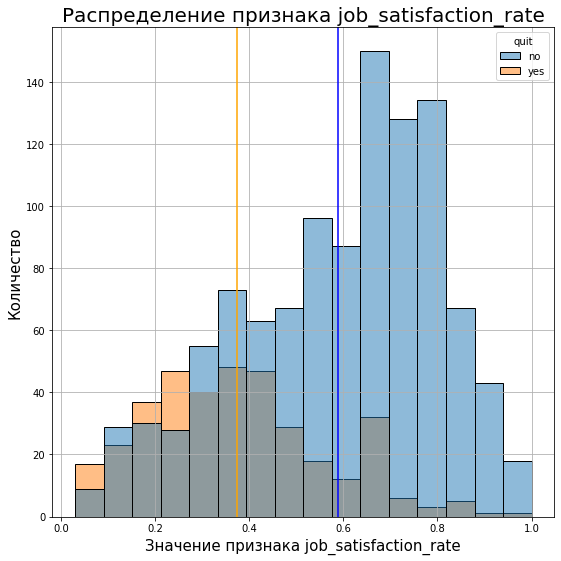

In [40]:
# создаем фигуру для гистограммы
fig, axes = plt.subplots(figsize=(9, 9))

# построение гистограммы job_satisfaction_rate с разбивкой по целевому признаку quit
sns.histplot(test_features, x='job_satisfaction_rate', hue='quit', ax=axes)
plt.title(f'Распределение признака job_satisfaction_rate', fontsize=20)
plt.ylabel(f'Количество', fontsize=15)
plt.xlabel(f'Значение признака job_satisfaction_rate', fontsize=15)
plt.grid()
plt.axvline(test_features.query('quit == "no"')['job_satisfaction_rate'].mean(),  color='blue')
plt.axvline(test_features.query('quit == "yes"')['job_satisfaction_rate'].mean(), color='orange')
plt.show()

Аналитики были правы, действительно уровень удовлетворённости сотрудника работой в компании у уволившихся и оставшихся сотрудников распределены по разному:
- среднее значение удовлетворенности уволившихся сотрудников на 0,2 пункта меньше, удовлетворенности оставшихся сотрудников;
- почти половина сотрудников с удовлетворенностью до 0,5 ушла из компании.

#### Вывод по исследовательскому анализу

Вывод по исследовательскому анализу:
- количественные признаки в `train_quit` распределены также как и в `train_job_satisfaction_rate`;
- категориальные признаки распределены также как и в `train_job_satisfaction_rate`, только сотрудников с уровнем `middle` больше чем `junior`, в `train_job_satisfaction_rate` их было поровну;
- оставшихся сотрудников в три зара больше, чем сотрудников, которые уволились;
- портрет "уволившегося сотрудника":
    - работает в среднем два года;
    - средняя оценка качества работы сотрудника, которую дал руководитель 3 (для оставшихся средняя оценка 3,5);
    - средняя зарплата на уровне 25000;
    - не важно в каком отделе работает;
    - с большой вероятностью это сотрудник с уровнем занимаемой должности `junior`;
    - уровень загруженности сотрудника `low` или `medium`;
    - его не повышали за последний год;
    - скорее всего сотрудник нарушаю трудовой договор;
    - уровень удовлетворенности работой у него меньше 0,5.

### Добавление нового входного признака

Основываясь на выводах из предыдущего блока, можно сказать, что уровень удовлетворенности сотрудника работой в компании влияет на то, уволится ли сотрудник, поэтому добавим в тренировочную выборку `train_quit` этот признак. 

Добавлять новый признак будем с помощью лучшей модели для предсказания уровня удовлетворенности сотрудника работой в компании `best_model_job_satisfaction_rate`, она уже обучена, так что просто добавим новый столбец с предсказаниями в `train_quit`:

In [41]:
# добавление предсказаний уровня удовлетворенности сотрудника работой в компании
train_quit['job_satisfaction_rate'] = best_model_job_satisfaction_rate.predict(train_quit.drop(['id', 'quit'], axis=1))

print(f"""
Размер test_features: {train_quit.shape}
Количество пропусков в столбце pred_job_satisfaction_rate: {train_quit["job_satisfaction_rate"].isna().sum()}
Диапазон значений в столбце job_satisfaction_rate ({round(train_quit["job_satisfaction_rate"].min(), 2)}, \
{round(train_quit["job_satisfaction_rate"].max(), 2)})
"""
     )


Размер test_features: (2587, 11)
Количество пропусков в столбце pred_job_satisfaction_rate: 0
Диапазон значений в столбце job_satisfaction_rate (0.06, 0.99)



Размер датафрейма корректный, пропусков в новом столбце нет, диапазон значений корректный - предсказания добавились корректно

### Корреляционный анализ

Для нахождения зависимостей признаков воспользуемся коэффициентом Фи (признаки: `employment_years` и `supervisor_evaluation` больше похожи на категориальные признаки (мало уникальных значений) не будем их указывать в параметре `interval_cols`, где отобразим непрерывные признаки):

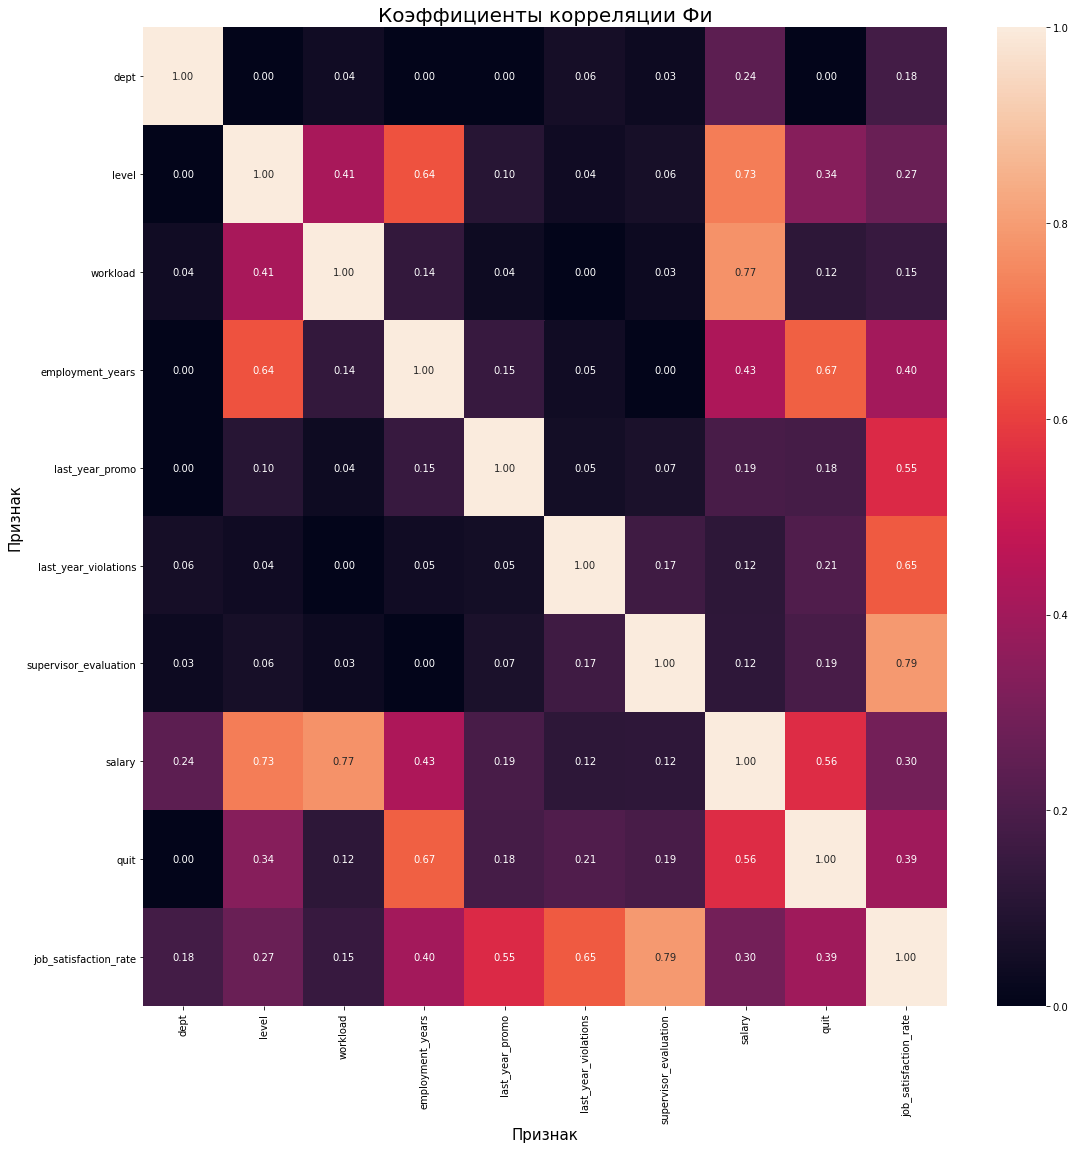

In [42]:
plt.subplots(figsize=(18, 18))
# тепловая карта коэффициентов корреляции Фи
sns.heatmap(train_quit.drop('id', axis=1)
            .phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']),
            annot=True, 
            fmt=".2f")
plt.ylabel('Признак', fontsize=15)
plt.xlabel('Признак', fontsize=15)
plt.title('Коэффициенты корреляции Фи', fontsize=20)
plt.show()

По тепловой карте коэффициентов Фи видно, что:
- целевой признак `quit` средне коррелирует с длительностью работы в компании `employment_years` и зарплатой `salary` (коэффициент Фи 0,67 и 0,56 соответственно);
- также целевой признак совсем немного коррелирует с уровнем удовлетворённости сотрудника работой в компании `job_satisfaction_rate` и уровнем занимаемой должности `level` (коэффициент Фи 0,4 и 0,34 соответственно);
- с остальными признаками целевой признак практически не коррелирует;
- есть высока корреляция у `level` с `salary` и `employment_years`, а также у `salary` и `workload`, но о мультиколлинеарности речи не идет.

### Обучение и выбор лучшей модели классификации

Для кодирования и масштабирования признаков будем использовать `data_preprocessor`, предварительно добавив новый признак в список с названиями колличественных признаков `num_columns`:

In [43]:
# добавление нового признака в список num_columns
num_columns.append('job_satisfaction_rate')

Дальше создадим словарь с гиперпараметрами моделей, которые будем пробовать для предсказания увольнения сотрудника из компании:
- `KNeighborsClassifier()`:
    - будем изменять количество соседей `n_neighbors` от 3 до 53 с шагом 5;
- `DecisionTreeClassifier()`:
    - ограничим максилальную глубину дерева `max_depth` от 3 до 10;
    - ограничим число листьев от `max_features` 3 до 10;
- `LogisticRegression()`:
    - гиперпараметр регуляризации `С` от 1 до 5;
- `SVC()`:
    - вид ядра `kernel`: `linear`, `rbf`, `sigmoid`;
- для всех моделей переберем два варианта масштабирования: `StandardScaler`, `MinMaxScaler`:

In [44]:
param_distributions_quit = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models':[ KNeighborsClassifier()], # модель
        'models__n_neighbors': range(3, 53, 5), # количество соседей от 3 до 53 с шагом 5
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] # два варианта масштабирования
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=42)], # модель
        'models__max_depth': range(3, 10), # ограничение максимальной глубины дерева
        'models__max_features': range(3, 10), # число листьев
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] # два варианта масштабирования
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=42, penalty='l2')], # модель
        'models__C': range(1, 5), # параметр С
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] # два варианта масштабирования
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=42, probability=True)], # модель
        'models__kernel': ['linear', 'rbf', 'sigmoid'], # ядро решения
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] # два варианта масштабирования
    }
]

Словарь готов, теперь создадим тренировочную выборку:

In [45]:
# создание тренировочной выборки и y_train_quit
X_train_quit = train_quit.drop(['id', 'quit'], axis=1)
y_train_quit = train_quit['quit']

Тренировочная выборка готова, теперь с помощью `RandomizedSearchCV` выберем лучшую модель на основе метрики `roc_auc` и посмотрим на параметры лучшей модели и ее метрику:

In [46]:
# выбор лучшей модели с помощью RandomizedSearchCV
randomized_search_quit = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions_quit, 
    cv=5,
    random_state=15,
    scoring='roc_auc',
    n_jobs=-1
)

# обучение лучшей модели на тренировочной выборке
randomized_search_quit.fit(X_train_quit, y_train_quit)

# параметры лучшей модели
params_best_model = (pd.DataFrame(randomized_search_quit.cv_results_)[['rank_test_score', 'params']]
                     .sort_values('rank_test_score')
                     .reset_index(drop=True)['params']
                     .loc[pd.DataFrame(randomized_search_quit.cv_results_).index[0]]
                    )

print('Лучшая модель и её параметры:\n\n', params_best_model)
print ('\nМетрика лучшей модели на тренировочной выборке:', randomized_search_quit.best_score_.round(3))

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__n_neighbors': 18, 'models': KNeighborsClassifier()}

Метрика лучшей модели на тренировочной выборке: 0.905


Лучшей для предсказания увольнения стала модель `KNeighborsClassifier` с параметрами:
- количество соседей `n_neighbors` - 18;
- масштабирование: `StandardScaler`;
- метрика `roc_auc` при кросс-валидации на тренировочной выборке получилась 0,905.

Обучим лучшую модель на тренировочных данных (`X_train_quit`, `y_train_quit`), получим предсказания на тестовых `test_features` (без `id` и целевого признака `quit`) и посчитаем метрику `roc_auc`:

In [47]:
# получение лучшей модели из pipeline
best_model_quit = randomized_search_quit.best_estimator_

# обучение лучшей модели
best_model_quit.fit(X_train_quit, y_train_quit)

# получение вероятности предсказаний тестовой выборки
y_proba_quit = best_model_quit.predict_proba(test_features.drop(['id', 'quit'], axis=1))[:,1]

print(f'Метрика roc_auc на тестовой выборке:', roc_auc_score(y_test_quit, y_proba_quit).round(3))

Метрика roc_auc на тестовой выборке: 0.912


Метрика `roc_auc` на тестовой выборке получилась 0,912, что удовлетворяет критерию успеха (`roc_auc` ≥ 0,91).

### Вывод

Вывод по модели предсказания увольнения сотрудника:
- выбор был из четырех моделей классификации `KNeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression` и `SVC` и лучшей из них стала модель `KNeighborsClassifier` с параметрами:
    - количество соседей `n_neighbors` - 18;
    - масштабирование: `StandardScaler`;
    - метрика `roc_auc` при кросс-валидации на тренировочной выборке получилась 0,905;
- метрика `roc_auc` на тестовой выборке получилась 0,912, что удовлетворяет критерию успеха и получилась даже выше, чем при кросс-валидации на тренировочных данных (0,905).

## Общий вывод

В данном проекте было решено две задачи:
- первая: построение модели, которая сможет предсказать уровень удовлетворённости (от 0 до 1) сотрудника на основе данных заказчика;
- вторая: построение модели, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании (`yes`, `no`). 

В "Сборном проекте - 2" проделана работа по изучению данных и их предобработке, а именно были:
- были изучены данные с помощью методов `info` и `describe`;
- удалены неявные дубликаты.

**Решение первой задачи:**

В ходе решения первой задачи был проведен исследовательский анализ признаков и выявлено, что:
- сотрудников, работающих недавно больше, чем "стареньких" сотрудников;
- в основном руководитель оценивает сотрудников на 3 или 4;
- большая часть сотрудников получает зарплату до 60000 руб.;
- самый большой отдел - `sales`;
- больше всего сотрудников уровня `junior` и `middle`;
- всех больше сотрудников с загруженность `medium`;
- очень малая часть сотрудников получила повышение за последний год;
- чуть больше 500 сотрудников совершали нарушения трудового договора.

Так же был проведен корреляционный анализ и выявлено, что:
- целевой признак `job_satisfaction_rate` коррелирует с:
    - оценкой качества работы сотрудника, которую дал руководитель `supervisor_evaluation`;
    - наличием нарушения сотрудником трудового договора за последний год `last_year_violations`;
    - длительностью работы в компании `employment_years` (коэффициент Фи 0,32);
- с остальными признаками целевой признак практически не коррелирует;
- мультиколлинеарности признаков нет.

Потом с помощью `pipeline` и `RandomizedSearchCV` была выбрана лучшая модель для предсказания уровня удовлетворенности сотрудника:
- выбор был из двух моделей `LinearRegression` и `DecisionTreeRegressor`, лучшей оказалась более сложная модель, т.к. простая модель `LinearRegression` не смогла установить все зависимости, т.к. целевой признак не сильно коррелировал с входными признаками;
- **лучшей для предсказания уровня удовлетворенности сотрудника стала модель `DecisionTreeRegressor` с параметрами**:
    - максилальная глубина дерева `max_depth` 14;
    - число листьев `max_features`: неограничено - `None`;
    - минимальное число объектов в листе `min_samples_leaf`: 3;
    - критерий, по которому происходит разбиение вершины дерева `criterion`: `poisson`;
    - масштабирование: `MinMaxScaler`;
- метрика `SMAPE` при на тестовой выборке получилась равной 14,85.

**Решение второй задачи:**

В ходе решения второй задачи был проведен исследовательский анализ признаков и выявлено, что:
- количественные признаки данных для второй задачи распределены также как и данны для первой;
- категориальные признаки распределены также как данные для первой задачи, только сотрудников с уровнем `middle` больше чем `junior`, в первой задаче их было поровну;
- оставшихся сотрудников в три зара больше, чем сотрудников, которые уволились;

Так же был составлен портрет "уволившегося сотрудника":
- работает в среднем два года;
- средняя оценка качества работы сотрудника, которую дал руководитель 3 (для оставшихся средняя оценка 3,5);
- средняя зарплата на уровне 25000;
- не важно в каком отделе работает;
- с большой вероятностью это сотрудник с уровнем занимаемой должности `junior`;
- уровень загруженности сотрудника `low` или `medium`;
- его не повышали за последний год;
- скорее всего сотрудник нарушает трудовой договор;
- уровень удовлетворенности работой у него меньше 0,5.

Еще был добавлен новый признак: уровень удовлетворённости сотрудника, который получили с помощью модели выбранной при решении первой задачи.

Так же был проведен корреляционный анализ и выявлено, что:
- целевой признак `quit` коррелирует с:
    - длительностью работы в компании `employment_years`;
    - зарплатой `salary`;
    - уровнем удовлетворённости сотрудника работой в компании `job_satisfaction_rate`;
    - уровнем занимаемой должности `level`;
- с остальными признаками целевой признак практически не коррелирует.

Потом с помощью `pipeline` и `RandomizedSearchCV` была выбрана лучшая модель для предсказания увольнения сотрудника из компании:
- выбор был из четырех моделей классификации `KNeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression` и `SVC`;
- **лучшей стала модель `KNeighborsClassifier` с параметрами**:
    - количество соседей `n_neighbors` - 18;
    - масштабирование: `StandardScaler`;
- метрика `roc_auc` на тестовой выборке получилась 0,912.

**Предложения для бизнеса**

Так как увольняются сотрудники в основном с опытом работы до двух лет, с уровнем занимаемой должности `junior`, уровнем удовлетворенности работой меньше 0,5 и низкой зарплатой необходимо как-то стимулировать сотрудников оставаться в компании, например:
- вводить какие-нибудь корпоративные "плюшки":
    - симки с корпоративным тарифом (дешевым);
    - скидки в фитнесс-залы;
    - проведение спортивно-массовых мероприятий (тимбилдинг);
    - скидки в столовую;
    - полис ДМС;
- также можно ввести систему увеличения премии за каждый год стажа;
- оборудовать рабочее место с максимальным комфортом и минимумом раздражителей;
- серьезнее подходить при выборе кандидатов на открытые вакансии;
- назначать грамотных руководителей, которые смогут отстоять интересы своих подчиненных, подсказать и похвалить в нужный момент.